In [1]:
import sys
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
# sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot-py39/lib/python3.9/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
import joblib
from joblib import dump, load

print ( "numpy: {}".format(np.__version__) )
print ( "joblib: {}".format(joblib.__version__) )

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

['/eos/home-i01/a/antoniov/SWAN_projects/pps-dilepton-analysis', '/cvmfs/sft.cern.ch/lcg/releases/condor/23.0.2-81e01/x86_64-el9-gcc13-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages', '/usr/local/lib/swan/nb_term_lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python311.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.11.9-2924c/x86_64-el9-gcc13-opt/lib/python3.11/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11

2025-04-10 20:37:22.070724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 20:37:37.963961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sklearn: 1.5.1
tensorflow: 2.18.0


In [2]:
# get_data, process_data, fiducial_cuts, fiducial_cuts_all, aperture_parametrisation, check_aperture
from processing import *
# efficiencies_2017
from proton_efficiency import *

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

#data_periods = [ "2017B", "2017C1", "2017C2", "2017D", "2017E", "2017F1", "2017F2", "2017F3" ]
# data_periods = [ "2017B", "2017C1", "2017E", "2017F1" ]
data_periods = [ "2018A" ]

# run_tables = False

run_random_experiments = False


{'muon': {'2017B': 4.799881474, '2017C1': 5.785813941, '2017C2': 3.786684323, '2017D': 4.247682053, '2017E': 9.312832062, '2017F1': 1.738905587, '2017F2': 8.125575961, '2017F3': 3.674404546}, 'electron': {'2017B': 4.594096155565198, '2017C1': 5.521298099245362, '2017C2': 3.6135646891210857, '2017D': 4.0518639103567, '2017E': 8.906848461089172, '2017F1': 1.6584516422062712, '2017F2': 7.749629938012412, '2017F3': 3.504400870870218}}
Luminosity 2017 muon: 41.471779946999995
Luminosity 2017 electron: 39.60015376646642
{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


### Event selection

In [3]:
def select_events( df ):
    msk_evts_ = ( ( df["Muon0Pt"] >= 50. ) & ( df["Muon1Pt"] >= 50. ) & ( df["InvMass"] >= 110. ) & ( df["Acopl"] <= 0.009 ) & ( df["ExtraPfCands"] <= 1 ) )
    df = df.loc[ msk_evts_ ]
    msk1_ = ( ( df["Arm"] == 0 ) & ( df.loc[ :, "Xi"] >= 0.050 ) )
    msk2_ = ( ( df["Arm"] == 1 ) & ( df.loc[ :, "Xi"] >= 0.060 ) )
    msk_ = ( msk1_ | msk2_ )
    df = df.loc[ msk_ ]

    return df

## Signal

In [4]:
labels_signals = [
    'GGToMuMu_Pt-25_Elastic',
    'GGToMuMu_Pt-25_Inel-El'
]

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_signals:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]


GGToMuMu_Pt-25_Elastic
['/counts', '/events_multiRP', '/protons_multiRP']
GGToMuMu_Pt-25_Inel-El
['/counts', '/events_multiRP', '/protons_multiRP']


In [5]:
df_counts_signals

{'GGToMuMu_Pt-25_Elastic': All                   442360
 Muon                  275392
 Vertex                243030
 Protons_check_none    243030
 Protons                63365
 dtype: int64,
 'GGToMuMu_Pt-25_Inel-El': All                   442350
 Muon                  340920
 Vertex                304204
 Protons_check_none    304204
 Protons                44594
 dtype: int64}

In [6]:
df_signals_protons_multiRP_index

{'GGToMuMu_Pt-25_Elastic':                                                                BX  \
 Run LumiSection EventNum hash_id              Slice                 
 1   1           4        8877239199479242098  0      4.294967e+09   
                 16       16934084880806892105 0      4.294967e+09   
                 23       11425524222376434749 0      4.294967e+09   
                 22       11957597614479949338 0      4.294967e+09   
                 30       2779246979597450814  0      4.294967e+09   
 ...                                                           ...   
     4960        3075     12019210061968116861 0      4.294967e+09   
                 3088     15518503521974476713 0      4.294967e+09   
                 3099     9721565878191505164  0      4.294967e+09   
                 3079     10306354821070319388 0      4.294967e+09   
                 3098     12680979879057901420 0      4.294967e+09   
 
                                                      Crossing

In [7]:
df_signals_protons_multiRP_events

{'GGToMuMu_Pt-25_Elastic':                                                                BX  \
 Run LumiSection EventNum hash_id              Slice                 
 1   2           141      10990955965324816310 0      4.294967e+09   
     4           371      17746661951917755576 0      4.294967e+09   
     5           492      2990890362874645505  0      4.294967e+09   
     6           503      15002965146802841775 0      4.294967e+09   
     15          1426     14550544664997994338 0      4.294967e+09   
 ...                                                           ...   
     4868        32       944804203629776360   0      4.294967e+09   
     4869        115      14679370508317095092 0      4.294967e+09   
     4876        814      5466718261774713112  0      4.294967e+09   
     4940        1033     7808695611144996636  0      4.294967e+09   
     4946        1619     9777719921969825435  0      4.294967e+09   
 
                                                      Crossing

In [8]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           4        8877239199479242098  0      4.294967e+09   
                16       16934084880806892105 0      4.294967e+09   
                23       11425524222376434749 0      4.294967e+09   
                22       11957597614479949338 0      4.294967e+09   
                30       2779246979597450814  0      4.294967e+09   
...                                                           ...   
    4960        3075     12019210061968116861 0      4.294967e+09   
                3088     15518503521974476713 0      4.294967e+09   
                3099     9721565878191505164  0      4.294967e+09   
                3079     10306354821070319388 0      4.294967e+09   
                3098     12680979879057901420 0      4.294967e+09   

                                                     CrossingAngle  MultiRP  \
Run LumiSection EventNum hash_id              Slice                           
1   1           4        8877239199479242098  0              140.0        1   
                16       16934084880806892105 0              140.0        1   
                23       11425524222376434749 0              140.0        1   
                22       11957597614479949338 0              140.0        1   
                30       2779246979597450814  0              140.0        1   
...                                                            ...      ...   
    4960        3075     12019210061968116861 0              140.0        1   
                3088     15518503521974476713 0              140.0        1   
                3099     9721565878191505164  0              140.0        1   
                3079     10306354821070319388 0              140.0        1   
                3098     12680979879057901420 0              140.0        1   

                                                     Arm  RPId1  RPId2  \
Run LumiSection EventNum hash_id              Slice                      
1   1           4        8877239199479242098  0        1    103    123   
                16       16934084880806892105 0        1    103    123   
                23       11425524222376434749 0        1    103    123   
                22       11957597614479949338 0        0      3     23   
                30       2779246979597450814  0        1    103    123   
...                                                  ...    ...    ...   
    4960        3075     12019210061968116861 0        1    103    123   
                3088     15518503521974476713 0        0      3     23   
                3099     9721565878191505164  0        1    103    123   
                3079     10306354821070319388 0        1    103    123   
                3098     12680979879057901420 0        1    103    123   

                                                      TrackX1   TrackY1  \
Run LumiSection EventNum hash_id              Slice                       
1   1           4        8877239199479242098  0      3.544312  1.933838   
                16       16934084880806892105 0      3.831085  2.075195   
                23       11425524222376434749 0      4.016235  1.848755   
                22       11957597614479949338 0      7.029358  1.482666   
                30       2779246979597450814  0      4.119202  1.661255   
...                                                       ...       ...   
    4960        3075     12019210061968116861 0      4.144287  2.573730   
                3088     15518503521974476713 0      4.547302  1.689209   
                3099     9721565878191505164  0      3.196289  1.682983   
                3079     10306354821070319388 0      4.240356  2.435547   
                3098     12680979879057901420 0      5.206421  1.561646   

                                                      TrackX2   TrackY2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           4        8877239199479

In [9]:
groupby_ = df_signals_protons_multiRP_index[ label_ ].groupby( ['Run', 'LumiSection', 'EventNum', 'hash_id', 'Slice' ] )
# gb_ = groupby_.groups
# for key_, values_ in gb_.items():
#     print ( key_, values_ )
#     print( df_signals_protons_multiRP_events[ label_ ][ [ 'Xi', 'Arm' ] ].loc[ values_ ], "\n\n")
msk_ = groupby_[ 'Xi' ].transform( lambda s_: s_.size > 1 )
print ( msk_, np.sum(msk_) )

Run  LumiSection  EventNum  hash_id               Slice
1    1            4         8877239199479242098   0        False
                  16        16934084880806892105  0        False
                  23        11425524222376434749  0        False
                  22        11957597614479949338  0        False
                  30        2779246979597450814   0        False
                                                           ...  
     4960         3075      12019210061968116861  0        False
                  3088      15518503521974476713  0        False
                  3099      9721565878191505164   0        False
                  3079      10306354821070319388  0        False
                  3098      12680979879057901420  0        False
Name: Xi, Length: 61786, dtype: bool 1096


In [10]:
df_signals_protons_multiRP_index[ label_ ][ msk_ ][ 'Xi' ]

Run  LumiSection  EventNum  hash_id               Slice
1    2            141       10990955965324816310  0        0.071457
                                                  0        0.041645
     4            371       17746661951917755576  0        0.069926
                                                  0        0.053824
     5            492       2990890362874645505   0        0.073861
                                                             ...   
     4876         814       5466718261774713112   0        0.053527
     4940         1033      7808695611144996636   0        0.039941
                                                  0        0.074964
     4946         1619      9777719921969825435   0        0.042875
                                                  0        0.049267
Name: Xi, Length: 1096, dtype: float32

In [11]:
df_signals_protons_multiRP_index[ label_ ][
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Xi', 'T', 'ThX', 'ThY'] ]

MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           4        8877239199479242098  0            1    1    103   
                16       16934084880806892105 0            1    1    103   
                23       11425524222376434749 0            1    1    103   
                22       11957597614479949338 0            1    0      3   
                30       2779246979597450814  0            1    1    103   
...                                                      ...  ...    ...   
    4960        3075     12019210061968116861 0            1    1    103   
                3088     15518503521974476713 0            1    0      3   
                3099     9721565878191505164  0            1    1    103   
                3079     10306354821070319388 0            1    1    103   
                3098     12680979879057901420 0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           4        8877239199479242098  0        123  3.544312   
                16       16934084880806892105 0        123  3.831085   
                23       11425524222376434749 0        123  4.016235   
                22       11957597614479949338 0         23  7.029358   
                30       2779246979597450814  0        123  4.119202   
...                                                    ...       ...   
    4960        3075     12019210061968116861 0        123  4.144287   
                3088     15518503521974476713 0         23  4.547302   
                3099     9721565878191505164  0        123  3.196289   
                3079     10306354821070319388 0        123  4.240356   
                3098     12680979879057901420 0        123  5.206421   

                                                      TrackY1   TrackX2  \
Run LumiSection EventNum hash_id              Slice                       
1   1           4        8877239199479242098  0      1.933838  3.539795   
                16       16934084880806892105 0      2.075195  3.843445   
                23       11425524222376434749 0      1.848755  4.147095   
                22       11957597614479949338 0      1.482666  7.253113   
                30       2779246979597450814  0      1.661255  4.223022   
...                                                       ...       ...   
    4960        3075     12019210061968116861 0      2.573730  4.147095   
                3088     15518503521974476713 0      1.689209  4.520386   
                3099     9721565878191505164  0      1.682983  3.160248   
                3079     10306354821070319388 0      2.435547  4.298889   
                3098     12680979879057901420 0      1.561646  5.361633   

                                                      TrackY2  \
Run LumiSection EventNum hash_id              Slice             
1   1           4        8877239199479242098  0      2.100098   
                16       16934084880806892105 0      2.199951   
                23       11425524222376434749 0      1.949951   
                22       11957597614479949338 0      1.550049   
                30       2779246979597450814  0      1.650024   
...                                                       ...   
    4960        3075     12019210061968116861 0      2.800049   
                3088     15518503521974476713 0      1.800049   
                3099     9721565878191505164  0      1.849976   
                3079     10306354821070319388 0      2.699951   
                3098     12680979879057901420 0      1.550049   

                                                     TrackThX_SingleRP  \
Run LumiSection EventNum hash_id              Slice                      
1   1           4        8877239199479242098  0                 -999.0   
                16       16934084880806892105 0                 -999.0   
         

In [12]:
df_signals_protons_multiRP_events[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   2           141      10990955965324816310 0      4.294967e+09   
    4           371      17746661951917755576 0      4.294967e+09   
    5           492      2990890362874645505  0      4.294967e+09   
    6           503      15002965146802841775 0      4.294967e+09   
    15          1426     14550544664997994338 0      4.294967e+09   
...                                                           ...   
    4868        32       944804203629776360   0      4.294967e+09   
    4869        115      14679370508317095092 0      4.294967e+09   
    4876        814      5466718261774713112  0      4.294967e+09   
    4940        1033     7808695611144996636  0      4.294967e+09   
    4946        1619     9777719921969825435  0      4.294967e+09   

                                                     CrossingAngle  \
Run LumiSection EventNum hash_id              Slice                  
1   2           141      10990955965324816310 0              140.0   
    4           371      17746661951917755576 0              140.0   
    5           492      2990890362874645505  0              140.0   
    6           503      15002965146802841775 0              140.0   
    15          1426     14550544664997994338 0              140.0   
...                                                            ...   
    4868        32       944804203629776360   0              140.0   
    4869        115      14679370508317095092 0              140.0   
    4876        814      5466718261774713112  0              140.0   
    4940        1033     7808695611144996636  0              140.0   
    4946        1619     9777719921969825435  0              140.0   

                                                        Muon0Pt  Muon0Eta  \
Run LumiSection EventNum hash_id              Slice                         
1   2           141      10990955965324816310 0      153.910522 -0.717777   
    4           371      17746661951917755576 0      113.645897  2.033875   
    5           492      2990890362874645505  0      179.275177 -2.138395   
    6           503      15002965146802841775 0      411.214081 -0.351422   
    15          1426     14550544664997994338 0      254.789871 -0.345794   
...                                                         ...       ...   
    4868        32       944804203629776360   0      200.304749  0.595959   
    4869        115      14679370508317095092 0      140.631622 -1.201829   
    4876        814      5466718261774713112  0       55.618614  1.976904   
    4940        1033     7808695611144996636  0      295.873444 -0.289576   
    4946        1619     9777719921969825435  0      199.936859  0.289129   

                                                     Muon0Phi  Muon0VtxZ  \
Run LumiSection EventNum hash_id              Slice                        
1   2           141      10990955965324816310 0     -2.970103  -0.679328   
    4           371      17746661951917755576 0      2.932525   1.892356   
    5           492      2990890362874645505  0     -0.470264  -1.907052   
    6           503      15002965146802841775 0      2.866833  -3.243670   
    15          1426     14550544664997994338 0      2.645186  -1.710790   
...                                                       ...        ...   
    4868        32       944804203629776360   0      1.876841  -2.186172   
    4869        115      14679370508317095092 0     -2.403518  -1.386012   
    4876        814      5466718261774713112  0     -0.435872  -0.045497   
    4940        1033     7808695611144996636  0     -1.385440  -2.054685   
    4946        1619     9777719921969825435  0     -2.565197   3.317078   

                                                        Muon1Pt  Muon1Eta  \
Run LumiSection EventNum hash_id              Slice                         
1   2           141      10990955965324816310 0      153.808319  1.502419   
    4           371      1774666

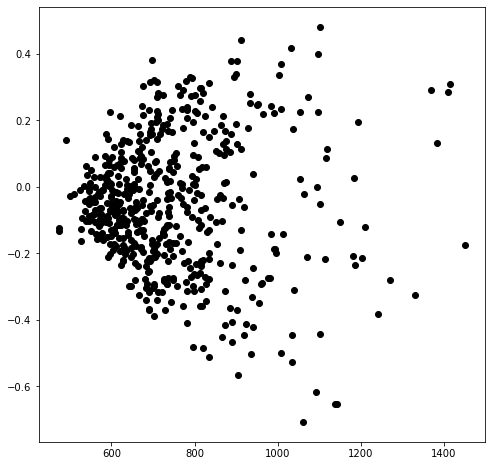

In [13]:
fig= plt.figure( figsize=(8,8) )
plt.plot( df_signals_protons_multiRP_events[ label_ ]['MX_nom'], df_signals_protons_multiRP_events[ label_ ]['YX_nom'], 'ko' )

In [14]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           22       14375974643974397545 0      4.294967e+09   
                38       15496648803556727214 0      4.294967e+09   
                45       12236195410975770477 0      4.294967e+09   
                79       3503070786304947039  0      4.294967e+09   
                80       13696300213981571301 0      4.294967e+09   
...                                                           ...   
    419         1951     5187105595686378284  0      4.294967e+09   
                1985     1459481711850609917  0      4.294967e+09   
                1982     14652981473528389649 0      4.294967e+09   
                1995     13115338871090092894 0      4.294967e+09   
                1986     5956423337043843000  0      4.294967e+09   

                                                     CrossingAngle  MultiRP  \
Run LumiSection EventNum hash_id              Slice                           
1   1           22       14375974643974397545 0              140.0        1   
                38       15496648803556727214 0              140.0        1   
                45       12236195410975770477 0              140.0        1   
                79       3503070786304947039  0              140.0        1   
                80       13696300213981571301 0              140.0        1   
...                                                            ...      ...   
    419         1951     5187105595686378284  0              140.0        1   
                1985     1459481711850609917  0              140.0        1   
                1982     14652981473528389649 0              140.0        1   
                1995     13115338871090092894 0              140.0        1   
                1986     5956423337043843000  0              140.0        1   

                                                     Arm  RPId1  RPId2  \
Run LumiSection EventNum hash_id              Slice                      
1   1           22       14375974643974397545 0        1    103    123   
                38       15496648803556727214 0        1    103    123   
                45       12236195410975770477 0        0      3     23   
                79       3503070786304947039  0        0      3     23   
                80       13696300213981571301 0        1    103    123   
...                                                  ...    ...    ...   
    419         1951     5187105595686378284  0        0      3     23   
                1985     1459481711850609917  0        0      3     23   
                1982     14652981473528389649 0        1    103    123   
                1995     13115338871090092894 0        0      3     23   
                1986     5956423337043843000  0        1    103    123   

                                                      TrackX1   TrackY1  \
Run LumiSection EventNum hash_id              Slice                       
1   1           22       14375974643974397545 0      4.715027  1.240112   
                38       15496648803556727214 0      4.418518  2.258789   
                45       12236195410975770477 0      4.650330  1.501709   
                79       3503070786304947039  0      7.679443  1.220581   
                80       13696300213981571301 0      4.760986  2.003906   
...                                                       ...       ...   
    419         1951     5187105595686378284  0      5.272583  1.437744   
                1985     1459481711850609917  0      5.667908  1.897217   
                1982     14652981473528389649 0      3.647308  1.746460   
                1995     13115338871090092894 0      4.650330  1.501709   
                1986     5956423337043843000  0      4.929443  2.986816   

                                                      TrackX2   TrackY2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           22       1437597464397

In [15]:
df_signals_protons_multiRP_index[ label_ ][ 
    ['MultiRP', 'Arm', 'RPId1', 'RPId2',
     'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
     'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
     'Xi', 'T', 'ThX', 'ThY']
    ]

MultiRP  Arm  RPId1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           22       14375974643974397545 0            1    1    103   
                38       15496648803556727214 0            1    1    103   
                45       12236195410975770477 0            1    0      3   
                79       3503070786304947039  0            1    0      3   
                80       13696300213981571301 0            1    1    103   
...                                                      ...  ...    ...   
    419         1951     5187105595686378284  0            1    0      3   
                1985     1459481711850609917  0            1    0      3   
                1982     14652981473528389649 0            1    1    103   
                1995     13115338871090092894 0            1    0      3   
                1986     5956423337043843000  0            1    1    103   

                                                     RPId2   TrackX1  \
Run LumiSection EventNum hash_id              Slice                    
1   1           22       14375974643974397545 0        123  4.715027   
                38       15496648803556727214 0        123  4.418518   
                45       12236195410975770477 0         23  4.650330   
                79       3503070786304947039  0         23  7.679443   
                80       13696300213981571301 0        123  4.760986   
...                                                    ...       ...   
    419         1951     5187105595686378284  0         23  5.272583   
                1985     1459481711850609917  0         23  5.667908   
                1982     14652981473528389649 0        123  3.647308   
                1995     13115338871090092894 0         23  4.650330   
                1986     5956423337043843000  0        123  4.929443   

                                                      TrackY1   TrackX2  \
Run LumiSection EventNum hash_id              Slice                       
1   1           22       14375974643974397545 0      1.240112  4.526611   
                38       15496648803556727214 0      2.258789  4.450745   
                45       12236195410975770477 0      1.501709  4.748108   
                79       3503070786304947039  0      1.220581  8.012207   
                80       13696300213981571301 0      2.003906  4.678467   
...                                                       ...       ...   
    419         1951     5187105595686378284  0      1.437744  5.279480   
                1985     1459481711850609917  0      1.897217  5.734924   
                1982     14652981473528389649 0      1.746460  3.615723   
                1995     13115338871090092894 0      1.501709  4.823975   
                1986     5956423337043843000  0      2.986816  5.133911   

                                                      TrackY2  \
Run LumiSection EventNum hash_id              Slice             
1   1           22       14375974643974397545 0      1.199951   
                38       15496648803556727214 0      2.399902   
                45       12236195410975770477 0      1.550049   
                79       3503070786304947039  0      1.300049   
                80       13696300213981571301 0      2.100098   
...                                                       ...   
    419         1951     5187105595686378284  0      1.449951   
                1985     1459481711850609917  0      2.100098   
                1982     14652981473528389649 0      1.800049   
                1995     13115338871090092894 0      1.599976   
                1986     5956423337043843000  0      3.350098   

                                                     TrackThX_SingleRP  \
Run LumiSection EventNum hash_id              Slice                      
1   1           22       14375974643974397545 0                 -999.0   
                38       15496648803556727214 0                 -999.0   
         

### Normalization of signal samples

In [16]:
# L_B  = 2.360904801;
# L_C1 = 5.313012839;
# L_E  = 8.958810514;
# L_F1 = 1.708478656;
# lumi_periods = {}
# lumi_periods[ "2017B" ]  = L_B
# lumi_periods[ "2017C1" ] = L_C1
# lumi_periods[ "2017E" ]  = L_E
# lumi_periods[ "2017F1" ] = L_F1
# print ( lumi_periods )
# np.sum( list( lumi_periods.values() ) )
print ( lumi_periods_2018 )
print ( "Luminosity 2018 muon: {}".format( np.sum( list( lumi_periods_2018[ 'muon' ].values() ) ) ) )
print ( "Luminosity 2018 electron: {}".format( np.sum( list( lumi_periods_2018[ 'electron' ].values() ) ) ) )

{'muon': {'2018A': 14.025827145867588, '2018B1': 6.620869367493728, '2018B2': 0.430376623828928, '2018C': 6.891684998276784, '2018D1': 20.939902986506983, '2018D2': 10.856932131702669}, 'electron': {'2018A': 13.088399561509418, '2018B1': 6.629521091507798, '2018B2': 0.430939012174748, '2018C': 6.8915954055654725, '2018D1': 20.94983928140255, '2018D2': 10.862083907209522}}
Luminosity 2018 muon: 59.76559325367668
Luminosity 2018 electron: 58.85237825936951


In [17]:
lumi_periods = lumi_periods_2018[ 'muon' ]
# lumi = np.sum( list( lumi_periods.values() ) )
lumi = lumi_periods['2018A'] + lumi_periods['2018B1'] + lumi_periods['2018B2']
print ( lumi )

norm_factors = {}
# norm_factors['Elastic'] = np.array( [ ( lumi / ( 200000 * test_sample_ratio ) ), 0.017254036*1000, 0.89 ] )
# norm_factors['SingleDissociation'] = np.array( [ ( lumi / ( 200000 * test_sample_ratio ) ), 0.025643100*1000, 0.76 ] )
norm_factors[ 'GGToMuMu_Pt-25_Elastic' ] = np.array( [ ( lumi / 500000 ), 0.11247885*1000, 0.89 ] )
norm_factors[ 'GGToMuMu_Pt-25_Inel-El' ] = np.array( [ ( lumi / 500000 ), 0.14633895*1000, 0.76 ] )
for label_ in labels_signals:
    # df_signals[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_index[ label_ ]["norm"] = np.product( norm_factors[ label_ ] )

21.077073137190244


In [18]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           4        8877239199479242098  0      4.294967e+09   
                16       16934084880806892105 0      4.294967e+09   
                23       11425524222376434749 0      4.294967e+09   
                22       11957597614479949338 0      4.294967e+09   
                30       2779246979597450814  0      4.294967e+09   
...                                                           ...   
    4960        3075     12019210061968116861 0      4.294967e+09   
                3088     15518503521974476713 0      4.294967e+09   
                3099     9721565878191505164  0      4.294967e+09   
                3079     10306354821070319388 0      4.294967e+09   
                3098     12680979879057901420 0      4.294967e+09   

                                                     CrossingAngle  MultiRP  \
Run LumiSection EventNum hash_id              Slice                           
1   1           4        8877239199479242098  0              140.0        1   
                16       16934084880806892105 0              140.0        1   
                23       11425524222376434749 0              140.0        1   
                22       11957597614479949338 0              140.0        1   
                30       2779246979597450814  0              140.0        1   
...                                                            ...      ...   
    4960        3075     12019210061968116861 0              140.0        1   
                3088     15518503521974476713 0              140.0        1   
                3099     9721565878191505164  0              140.0        1   
                3079     10306354821070319388 0              140.0        1   
                3098     12680979879057901420 0              140.0        1   

                                                     Arm  RPId1  RPId2  \
Run LumiSection EventNum hash_id              Slice                      
1   1           4        8877239199479242098  0        1    103    123   
                16       16934084880806892105 0        1    103    123   
                23       11425524222376434749 0        1    103    123   
                22       11957597614479949338 0        0      3     23   
                30       2779246979597450814  0        1    103    123   
...                                                  ...    ...    ...   
    4960        3075     12019210061968116861 0        1    103    123   
                3088     15518503521974476713 0        0      3     23   
                3099     9721565878191505164  0        1    103    123   
                3079     10306354821070319388 0        1    103    123   
                3098     12680979879057901420 0        1    103    123   

                                                      TrackX1   TrackY1  \
Run LumiSection EventNum hash_id              Slice                       
1   1           4        8877239199479242098  0      3.544312  1.933838   
                16       16934084880806892105 0      3.831085  2.075195   
                23       11425524222376434749 0      4.016235  1.848755   
                22       11957597614479949338 0      7.029358  1.482666   
                30       2779246979597450814  0      4.119202  1.661255   
...                                                       ...       ...   
    4960        3075     12019210061968116861 0      4.144287  2.573730   
                3088     15518503521974476713 0      4.547302  1.689209   
                3099     9721565878191505164  0      3.196289  1.682983   
                3079     10306354821070319388 0      4.240356  2.435547   
                3098     12680979879057901420 0      5.206421  1.561646   

                                                      TrackX2   TrackY2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           4        8877239199479

### Proton efficiency

In [19]:
# strips_multitrack_efficiency, strips_sensor_efficiency, multiRP_efficiency, file_eff_strips, file_eff_multiRP = efficiencies_2017()

In [20]:
# period_ = "2017E"
# f_multiRP_ = lambda row: multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                 multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                 )
# df_signals['Elastic'].apply(
#     f_multiRP_,
#     axis=1
#     )

In [21]:
# for period_ in data_periods:
#     f_eff_all_ = None
#     if proton_selection == "SingleRP":
#         f_eff_multiRP_           = lambda row: multiRP_efficiency[ period_ ][ "45" if row["RPId1"] == 23 else "56" ].GetBinContent(
#                                         multiRP_efficiency[ period_ ][ "45" if row["RPId1"] == 23 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                                         )

#         f_eff_all_               = lambda row: f_eff_multiRP_(row)
        
#     elif proton_selection == "MultiRP":
#         f_eff_strips_multitrack_ = lambda row: strips_multitrack_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent( 1 )

#         f_eff_strips_sensor_     = lambda row: strips_sensor_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                                         strips_sensor_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX2"], row["TrackY2"] )
#                                         )

#         f_eff_multiRP_           = lambda row: multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].GetBinContent(
#                                         multiRP_efficiency[ period_ ][ "45" if row["Arm"] == 0 else "56" ].FindBin( row["TrackX1"], row["TrackY1"] )
#                                         )

#         f_eff_all_               = lambda row: f_eff_strips_multitrack_(row) * f_eff_strips_sensor_(row) * f_eff_multiRP_(row)
    
#     #df_signals['Elastic'][ 'eff_strips_multitrack_' + period_ ] = df_signals['Elastic'].apply( f_eff_strips_multitrack_, axis=1 )
#     #df_signals['Elastic'][ 'eff_strips_sensor_' + period_ ]     = df_signals['Elastic'].apply( f_eff_strips_sensor_, axis=1 )
#     #df_signals['Elastic'][ 'eff_multiRP_' + period_ ]           = df_signals['Elastic'].apply( f_eff_multiRP_, axis=1 )
    
#     df_signals['Elastic'][ 'eff_all_' + period_ ]               = df_signals['Elastic'].apply( f_eff_all_, axis=1 )
#     df_signals['SingleDissociation'][ 'eff_all_' + period_ ]    = df_signals['SingleDissociation'].apply( f_eff_all_, axis=1 )

In [22]:
# df_signals['Elastic'][ 'eff_all_weighted' ] = 0.
# df_signals['SingleDissociation'][ 'eff_all_weighted' ] = 0.
# for period_ in data_periods:
#     df_signals['Elastic'][ 'eff_all_weighted' ] = df_signals['Elastic'][ 'eff_all_weighted' ] + lumi_periods[ period_ ] * df_signals['Elastic'][ 'eff_all_' + period_ ]
#     df_signals['SingleDissociation'][ 'eff_all_weighted' ] = df_signals['SingleDissociation'][ 'eff_all_weighted' ] + lumi_periods[ period_ ] * df_signals['SingleDissociation'][ 'eff_all_' + period_ ]
# df_signals['Elastic'][ 'eff_all_weighted' ] = df_signals['Elastic'][ 'eff_all_weighted' ] / lumi
# df_signals['SingleDissociation'][ 'eff_all_weighted' ] = df_signals['SingleDissociation'][ 'eff_all_weighted' ] / lumi

### Random experiments

In [23]:
if run_random_experiments:
    from random_experiment import *
    
    np.random.seed( 42 )

    # per period, arm
    systematics = {}
    #systematics[ "Xi" ] = ( systematics_Xi_X, systematics_Xi_Y )
    #systematics[ "Xi" ] = get_systematics_vs_xi_ROOT( data_periods, fileName="reco_characteristics/reco_characteristics_version1.root" )
    systematics[ "Xi" ] = get_systematics_vs_xi_h5( data_periods, fileName="reco_characteristics/reco_characteristics_version1.h5" )
   
    print ( systematics )
    
    # random_experiment( df_signals['Elastic'], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
    # random_experiment( df_signals['SingleDissociation'], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
    # df_signals['Elastic'].loc[ :, "Xi" ] = df_signals['Elastic'].loc[ :, "Xi_smeared"]
    # df_signals['SingleDissociation'].loc[ :, "Xi" ] = df_signals['SingleDissociation'].loc[ :, "Xi_smeared"]
    for label_ in labels_signals:
        random_experiment( df_signals_protons_multiRP_index[ label_ ], data_periods=data_periods, lumi_weights=lumi_periods, variables=[ "Xi" ], variations=systematics )
        df_signals_protons_multiRP_index[ label_ ].loc[ :, "Xi" ] = df_signals_protons_multiRP_index[ label_ ].loc[ :, "Xi_smeared"]
    

In [24]:
#df_signals['Elastic'][ ["Xi","sigma_Xi","Xi_smeared"] ]

In [25]:
#df_signals['SingleDissociation'][ ["Xi","sigma_Xi","Xi_smeared"] ]

In [26]:
# df_signals['Elastic'] = select_events( df_signals['Elastic'], clf=clf, use_keras=use_keras, scaler=scaler, prob_cut=prob_cut )
# df_signals['SingleDissociation'] = select_events( df_signals['SingleDissociation'], clf=clf, use_keras=use_keras, scaler=scaler, prob_cut=prob_cut )
for label_ in labels_signals:
    df_signals_protons_multiRP_index[ label_ ] = select_events( df_signals_protons_multiRP_index[ label_ ] )

In [27]:
label_ = 'GGToMuMu_Pt-25_Elastic'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           95       8260787476665919189  0      4.294967e+09   
    2           106      3283661194556062914  0      4.294967e+09   
                141      10990955965324816310 0      4.294967e+09   
    3           204      6553443103905539637  0      4.294967e+09   
    4           354      10375966241026625239 0      4.294967e+09   
...                                                           ...   
    4957        2744     15233462665487113130 0      4.294967e+09   
    4958        2856     5933132936455421681  0      4.294967e+09   
    4960        3020     2830199854327862843  0      4.294967e+09   
                3068     2116997368620145172  0      4.294967e+09   
                3076     6323050985321337814  0      4.294967e+09   

                                                     CrossingAngle  MultiRP  \
Run LumiSection EventNum hash_id              Slice                           
1   1           95       8260787476665919189  0              140.0        1   
    2           106      3283661194556062914  0              140.0        1   
                141      10990955965324816310 0              140.0        1   
    3           204      6553443103905539637  0              140.0        1   
    4           354      10375966241026625239 0              140.0        1   
...                                                            ...      ...   
    4957        2744     15233462665487113130 0              140.0        1   
    4958        2856     5933132936455421681  0              140.0        1   
    4960        3020     2830199854327862843  0              140.0        1   
                3068     2116997368620145172  0              140.0        1   
                3076     6323050985321337814  0              140.0        1   

                                                     Arm  RPId1  RPId2  \
Run LumiSection EventNum hash_id              Slice                      
1   1           95       8260787476665919189  0        1    103    123   
    2           106      3283661194556062914  0        0      3     23   
                141      10990955965324816310 0        0      3     23   
    3           204      6553443103905539637  0        1    103    123   
    4           354      10375966241026625239 0        1    103    123   
...                                                  ...    ...    ...   
    4957        2744     15233462665487113130 0        1    103    123   
    4958        2856     5933132936455421681  0        0      3     23   
    4960        3020     2830199854327862843  0        0      3     23   
                3068     2116997368620145172  0        0      3     23   
                3076     6323050985321337814  0        1    103    123   

                                                      TrackX1   TrackY1  \
Run LumiSection EventNum hash_id              Slice                       
1   1           95       8260787476665919189  0      6.364624  3.138184   
    2           106      3283661194556062914  0      5.844727  2.275635   
                141      10990955965324816310 0      7.672485  1.270142   
    3           204      6553443103905539637  0      5.678284  1.476440   
    4           354      10375966241026625239 0      5.702026  2.944092   
...                                                       ...       ...   
    4957        2744     15233462665487113130 0      7.102417  3.342773   
    4958        2856     5933132936455421681  0      7.396851  2.140137   
    4960        3020     2830199854327862843  0      9.152222  2.740479   
                3068     2116997368620145172  0      8.648315  1.962646   
                3076     6323050985321337814  0      5.966431  1.062500   

                                                      TrackX2   TrackY2  ...  \
Run LumiSection EventNum hash_id              Slice                      ...   
1   1           95       8260787476665

In [28]:
label_ = 'GGToMuMu_Pt-25_Inel-El'
df_signals_protons_multiRP_index[ label_ ]

BX  \
Run LumiSection EventNum hash_id              Slice                 
1   1           154      15209605664775746177 0      4.294967e+09   
                467      8811078053110064394  0      4.294967e+09   
                525      13513361752151555439 0      4.294967e+09   
                798      1718120005742693813  0      4.294967e+09   
                813      1354134243948679018  0      4.294967e+09   
...                                                           ...   
    418         508      5308129761759598350  0      4.294967e+09   
                512      17284805493511305198 0      4.294967e+09   
                841      10611043329991172999 0      4.294967e+09   
    419         1155     9599218764695070749  0      4.294967e+09   
                1713     6657287441699726690  0      4.294967e+09   

                                                     CrossingAngle  MultiRP  \
Run LumiSection EventNum hash_id              Slice                           
1   1           154      15209605664775746177 0              140.0        1   
                467      8811078053110064394  0              140.0        1   
                525      13513361752151555439 0              140.0        1   
                798      1718120005742693813  0              140.0        1   
                813      1354134243948679018  0              140.0        1   
...                                                            ...      ...   
    418         508      5308129761759598350  0              140.0        1   
                512      17284805493511305198 0              140.0        1   
                841      10611043329991172999 0              140.0        1   
    419         1155     9599218764695070749  0              140.0        1   
                1713     6657287441699726690  0              140.0        1   

                                                     Arm  RPId1  RPId2  \
Run LumiSection EventNum hash_id              Slice                      
1   1           154      15209605664775746177 0        1    103    123   
                467      8811078053110064394  0        1    103    123   
                525      13513361752151555439 0        0      3     23   
                798      1718120005742693813  0        0      3     23   
                813      1354134243948679018  0        0      3     23   
...                                                  ...    ...    ...   
    418         508      5308129761759598350  0        1    103    123   
                512      17284805493511305198 0        1    103    123   
                841      10611043329991172999 0        0      3     23   
    419         1155     9599218764695070749  0        0      3     23   
                1713     6657287441699726690  0        0      3     23   

                                                       TrackX1   TrackY1  \
Run LumiSection EventNum hash_id              Slice                        
1   1           154      15209605664775746177 0       4.108154  3.376465   
                467      8811078053110064394  0      15.300293  2.828613   
                525      13513361752151555439 0       6.611755  1.726929   
                798      1718120005742693813  0      11.329346 -1.295898   
                813      1354134243948679018  0      10.192139  2.432129   
...                                                        ...       ...   
    418         508      5308129761759598350  0       6.122375  1.589355   
                512      17284805493511305198 0       7.000793  2.975098   
                841      10611043329991172999 0       7.171326  2.108643   
    419         1155     9599218764695070749  0      12.423584  1.281494   
                1713     6657287441699726690  0       6.351440  1.942749   

                                                       TrackX2   TrackY2  ...  \
Run LumiSection EventNum hash_id              Slice                       ...   
1   1           154    

## Background

In [29]:
# resample_factor = 20
# label = "data_random_resample_20"

# fileNames_bkg = [
#     'output/output-UL2017B-PreSel-Rnd-Res20.h5',
#     'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
#     'output/output-UL2017E-PreSel-Rnd-Res20_0.h5',
#     'output/output-UL2017E-PreSel-Rnd-Res20_1.h5',
#     'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
# ]

# import time
# print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
# time_s_ = time.time()

# df_counts_bkg, df_bkg = 2 * [None]

# if run_tables:
#     with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

#         df_counts_bkg_list_ = []
#         df_bkg_list_ = []
#         for file_ in fileNames_bkg:
#             df_counts_bkg_, df_bkg_ = get_data( [ file_ ] )
#             df_bkg_ = process_data( df_bkg_, proton_selection, min_mass = 110., within_aperture=True )
#             df_counts_bkg_list_.append( df_counts_bkg_ )
#             df_bkg_list_.append( df_bkg_ )

#         df_counts_bkg_ = df_counts_bkg_list_[0]
#         for idx_ in range( 1, len( df_counts_bkg_list_ ) ):
#             df_counts_bkg_ = df_counts_bkg_.add( df_counts_bkg_list_[idx_] )

#         df_bkg_ = pd.concat( df_bkg_list_ )
        
#         store_[ "counts" ] = df_counts_bkg_
#         store_[ "df" ] = df_bkg_

# with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
#     df_counts_bkg = store_[ "counts" ]
#     df_bkg = store_[ "df" ]
        
# time_e_ = time.time()
# print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

resample_factor = 50

labels_bkg = [
    '2018A-Excl-Pt1_30-Pt2_20-random-resample_50',
    '2018B-Excl-Pt1_30-Pt2_20-random-resample_50'
]

df_counts_bkg = {}
df_bkg_protons_multiRP_index = {}
df_bkg_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_bkg:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_bkg[ label_ ] = store_[ "counts" ]
        df_bkg_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_bkg_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]


2018A-Excl-Pt1_30-Pt2_20-random-resample_50
['/counts', '/events_multiRP', '/protons_multiRP']
2018B-Excl-Pt1_30-Pt2_20-random-resample_50
['/counts', '/events_multiRP', '/protons_multiRP']


In [30]:
df_counts_bkg

{'2018A-Excl-Pt1_30-Pt2_20-random-resample_50': All                      1247104400
 Muon                      138668900
 Vertex                    128119000
 Exclusive                     12250
 ProtonsRnd_check_none         12250
 ProtonsRnd                     9500
 dtype: int64,
 '2018B-Excl-Pt1_30-Pt2_20-random-resample_50': All                      542229000
 Muon                      75808700
 Vertex                    70091450
 Exclusive                     7600
 ProtonsRnd_check_none         7600
 ProtonsRnd                    5250
 dtype: int64}

In [31]:
df_bkg = pd.concat( df_bkg_protons_multiRP_index )
df_bkg

BX  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0       477.0   
                                                                                              0       477.0   
                                                                                              1       477.0   
                                                                                              1       477.0   
                                                                                              2       477.0   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48     1095.0   
                                                   83          94725888  13445504588736534904 48     3408.0   
                                                                                              48     3408.0   
                                                   331         467028512 555164197449763875   49     1095.0   
                                                                                              49     1095.0   

                                                                                                     CrossingAngle  \
                                            Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0              150.0   
                                                                                              0              150.0   
                                                                                              1              150.0   
                                                                                              1              150.0   
                                                                                              2              150.0   
...                                                                                                            ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48             154.0   
                                                   83          94725888  13445504588736534904 48             160.0   
                                                                                              48             160.0   
                                                   331         467028512 555164197449763875   49             154.0   
                                                                                              49             154.0   

                                                                                                     MultiRP  \
                                            Run    LumiSection EventNum  hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0            1   
                                                                                              0            1   
                                                                                              1            1   
                                                                                              1            1   
                                                                                              2            1   
...                                                                                                      ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   48           1   
                                                   83          94725888  13445504588736534904 48           1   
      

In [32]:
norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) ] )
df_bkg["norm"] = np.product( norm_factors['Bkg'] )

In [33]:
df_bkg = select_events( df_bkg )
df_bkg

BX  \
                                            Run    LumiSection EventNum  hash_id              Slice           
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0       477.0   
                                                                                              0       477.0   
                                                                                              1       477.0   
                                                                                              1       477.0   
                                                                                              2       477.0   
...                                                                                                     ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47     1095.0   
                                                   83          94725888  13445504588736534904 47     3408.0   
                                                                                              47     3408.0   
                                                   219         300424736 10554139707587351072 48     2204.0   
                                                                                              48     2204.0   

                                                                                                     CrossingAngle  \
                                            Run    LumiSection EventNum  hash_id              Slice                  
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0              150.0   
                                                                                              0              150.0   
                                                                                              1              150.0   
                                                                                              1              150.0   
                                                                                              2              150.0   
...                                                                                                            ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47             154.0   
                                                   83          94725888  13445504588736534904 47             160.0   
                                                                                              47             160.0   
                                                   219         300424736 10554139707587351072 48             157.0   
                                                                                              48             157.0   

                                                                                                     MultiRP  \
                                            Run    LumiSection EventNum  hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0            1   
                                                                                              0            1   
                                                                                              1            1   
                                                                                              1            1   
                                                                                              2            1   
...                                                                                                      ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47           1   
                                                   83          94725888  13445504588736534904 47           1   
      

In [34]:
df_bkg[ ['MultiRP', 'Arm', 'RPId1', 'RPId2',
         'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
         'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
         'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
         'Xi', 'T', 'ThX', 'ThY'] ]

MultiRP  \
                                            Run    LumiSection EventNum  hash_id              Slice            
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0            1   
                                                                                              0            1   
                                                                                              1            1   
                                                                                              1            1   
                                                                                              2            1   
...                                                                                                      ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47           1   
                                                   83          94725888  13445504588736534904 47           1   
                                                                                              47           1   
                                                   219         300424736 10554139707587351072 48           1   
                                                                                              48           1   

                                                                                                     Arm  \
                                            Run    LumiSection EventNum  hash_id              Slice        
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0        0   
                                                                                              0        0   
                                                                                              1        0   
                                                                                              1        0   
                                                                                              2        0   
...                                                                                                  ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47       1   
                                                   83          94725888  13445504588736534904 47       0   
                                                                                              47       1   
                                                   219         300424736 10554139707587351072 48       0   
                                                                                              48       1   

                                                                                                     RPId1  \
                                            Run    LumiSection EventNum  hash_id              Slice          
2018A-Excl-Pt1_30-Pt2_20-random-resample_50 315361 559         463781952 15618119849327436817 0          3   
                                                                                              0          3   
                                                                                              1          3   
                                                                                              1          3   
                                                                                              2          3   
...                                                                                                    ...   
2018B-Excl-Pt1_30-Pt2_20-random-resample_50 317626 331         467028512 555164197449763875   47       103   
                                                   83          94725888  13445504588736534904 47         3   
                                                                                              47       103   
                             

In [35]:
# #df_bkg["period"] = df_bkg["Run"].map( f_bkg_period_ )
# df_bkg.loc[ :, "period" ] = np.nan
# for idx_ in range( df_run_ranges.shape[0] ):
#     msk_period_ = ( ( df_bkg[ "Run" ] >= df_run_ranges.iloc[ idx_ ][ "min" ] ) & ( df_bkg[ "Run" ] <= df_run_ranges.iloc[ idx_ ][ "max" ] ) )
#     sum_period_ = np.sum( msk_period_ )
#     if sum_period_ > 0:
#         period_key_ = df_run_ranges.index[ idx_ ]
#         df_bkg.loc[ :, "period" ].loc[ msk_period_ ] = period_key_
#         print ( "{}: {}".format( period_key_, sum_period_ ) )

In [36]:
# if proton_selection == "MultiRP":
#     #df_bkg[ "within_aperture" ] = df_bkg.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )
#     df_bkg[ "within_aperture" ] = df_bkg.apply( lambda row: check_aperture( aperture_period_map[ row["period"] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )

In [37]:
#df_bkg[ ["Xi", "ThX", "period", "within_aperture" ] ]

In [38]:
# df_bkg = df_bkg[ df_bkg[ "within_aperture" ] ]
# df_bkg

7620 7501


/tmp/ipykernel_542/3133877251.py:13: RuntimeWarning: invalid value encountered in divide
  axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
/tmp/ipykernel_542/3133877251.py:19: RuntimeWarning: invalid value encountered in divide
  axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )


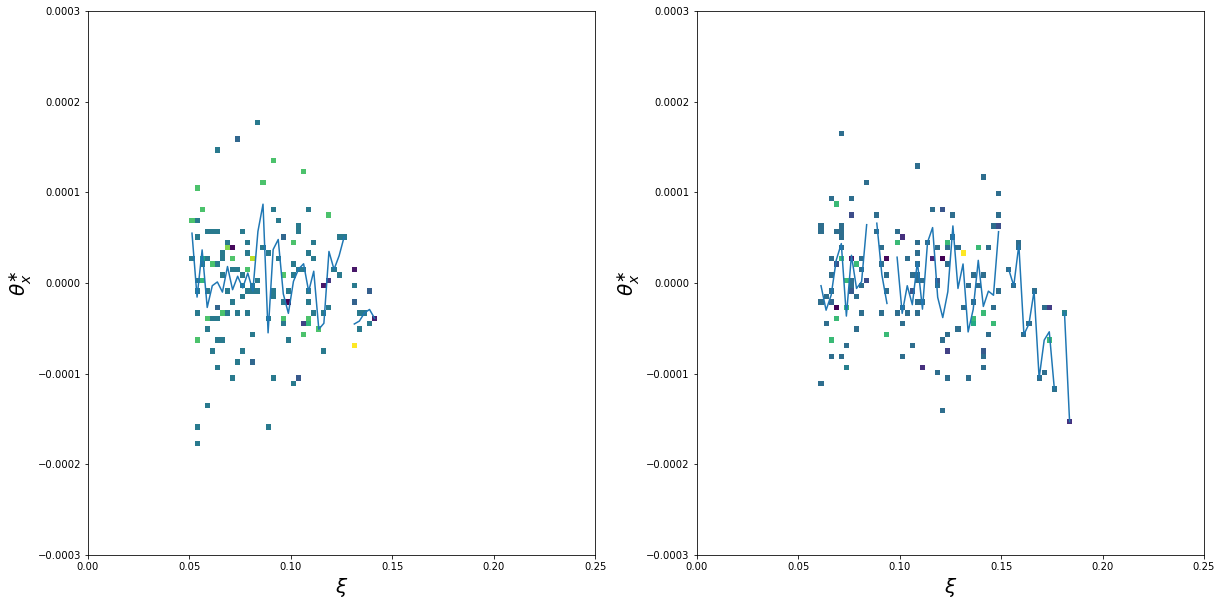

In [39]:
if proton_selection == "MultiRP":
    msk_bkg = ( df_bkg["InvMass"] >= 0. )
    # Multi-RP
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 0 )
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & ( df_bkg["Arm"] == 1 )

    print ( len(df_bkg[ "Xi" ][ msk1_bkg ]), len(df_bkg[ "Xi" ][ msk2_bkg ]) )

    fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
    h_, xedges_, yedges_, im_ = axes[0].hist2d( df_bkg[ "Xi" ][ msk1_bkg ], df_bkg[ "ThX" ][ msk1_bkg ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[0].set_xlabel( r"$\xi$", fontsize=20 )
    axes[0].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )
    h_, xedges_, yedges_, im_ = axes[1].hist2d( df_bkg[ "Xi" ][ msk2_bkg], df_bkg[ "ThX" ][ msk2_bkg ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[1].set_xlabel( r"$\xi$", fontsize=20 )
    axes[1].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )

In [40]:
# fig = plt.figure( figsize=(12,10) )
# plt.hist( df_bkg["probability"], histtype='step', color='orange', bins=60, range=(0.,1.), weights=df_bkg["norm"] )
# plt.hist( df_signals['SingleDissociation']["probability"], histtype='step', color='darkblue', bins=60, range=(0.,1.), weights=( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ) )
# plt.hist( df_signals['Elastic']["probability"], histtype='step', color='skyblue', bins=60, range=(0.,1.), weights=( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) )
# plt.yscale('log')

In [41]:
# fig = plt.figure( figsize=(12,10) )
# plt.hist(
#     [ df_bkg["probability"], df_signals['SingleDissociation']["probability"], df_signals['Elastic']["probability"] ],
#     color=[ 'orange', 'darkblue', 'skyblue' ],
#     weights=[ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ],
#     stacked=True, bins=60, range=(0.,1.) )
# plt.yscale('log')

## Data

In [42]:
# label = "data"

# fileNames_data = [
#     'output/output-UL2017B-PreSel.h5',
#     'output/output-UL2017C1-PreSel.h5',
#     'output/output-UL2017E-PreSel_0.h5',
#     'output/output-UL2017E-PreSel_1.h5',
#     'output/output-UL2017F1-PreSel.h5'
# ]

# import time
# print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
# time_s_ = time.time()

# df_counts_data, df_data = 2 * [None]

# if run_tables:
#     with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

#         df_counts_data_, df_data_ = get_data( fileNames_data )
#         df_data_ = process_data( df_data_, proton_selection=proton_selection, min_mass = 110., within_aperture=True )
        
#         store_[ "counts" ] = df_counts_data_
#         store_[ "df" ] = df_data_

# with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
#     df_counts_data = store_[ "counts" ]
#     df_data = store_[ "df" ]
        
# time_e_ = time.time()
# print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

labels_data = [
    '2018A-PreSel-Pt1_30-Pt2_20',
    '2018B-PreSel-Pt1_30-Pt2_20'
]

df_counts_data = {}
df_data_protons_multiRP_index = {}
df_data_protons_multiRP_events = {}

base_path_ = "output"
for label_ in labels_data:
    print ( label_ )
    file_path_ = "data-store-test-{}.h5".format( label_ )
    if base_path_ is not None and base_path_ != "": file_path_ = "{}/{}".format( base_path_, file_path_ )
        
    with pd.HDFStore( file_path_, 'r' ) as store_:
        print ( list( store_ ) )
        df_counts_data[ label_ ] = store_[ "counts" ]
        df_data_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_data_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]
        

2018A-PreSel-Pt1_30-Pt2_20
['/counts', '/events_multiRP', '/protons_multiRP']
2018B-PreSel-Pt1_30-Pt2_20
['/counts', '/events_multiRP', '/protons_multiRP']


In [43]:
df_data = pd.concat( df_data_protons_multiRP_index )
df_data

BX  \
                           Run    LumiSection EventNum  hash_id              Slice           
2018A-PreSel-Pt1_30-Pt2_20 315257 18          12676441  5796872166272854703  0      2275.0   
                                              12713573  17214442197243756059 0      1337.0   
                                                                             0      1337.0   
                                              12443853  18131936398322936006 0      2231.0   
                                              12636238  3906265580179621004  0      2839.0   
...                                                                                    ...   
2018B-PreSel-Pt1_30-Pt2_20 317626 172         230329792 10973903092416634292 0      2556.0   
                                              229507824 11001146759105990960 0       324.0   
                                              229862544 842839107057339153   0      2135.0   
                                              229944384 17183679887351449755 0       668.0   
                                                                             0       668.0   

                                                                                    CrossingAngle  \
                           Run    LumiSection EventNum  hash_id              Slice                  
2018A-PreSel-Pt1_30-Pt2_20 315257 18          12676441  5796872166272854703  0              150.0   
                                              12713573  17214442197243756059 0              150.0   
                                                                             0              150.0   
                                              12443853  18131936398322936006 0              150.0   
                                              12636238  3906265580179621004  0              150.0   
...                                                                                           ...   
2018B-PreSel-Pt1_30-Pt2_20 317626 172         230329792 10973903092416634292 0              159.0   
                                              229507824 11001146759105990960 0              159.0   
                                              229862544 842839107057339153   0              159.0   
                                              229944384 17183679887351449755 0              159.0   
                                                                             0              159.0   

                                                                                    MultiRP  \
                           Run    LumiSection EventNum  hash_id              Slice            
2018A-PreSel-Pt1_30-Pt2_20 315257 18          12676441  5796872166272854703  0            1   
                                              12713573  17214442197243756059 0            1   
                                                                             0            1   
                                              12443853  18131936398322936006 0            1   
                                              12636238  3906265580179621004  0            1   
...                                                                                     ...   
2018B-PreSel-Pt1_30-Pt2_20 317626 172         230329792 10973903092416634292 0            1   
                                              229507824 11001146759105990960 0            1   
                                              229862544 842839107057339153   0            1   
                                              229944384 17183679887351449755 0            1   
                                                                             0            1   

                                                                                    Arm  \
                           Run    LumiSection EventNum  hash_id              Slice        
2018A-PreSel-Pt1_30-Pt2_20 315257 18          12676441  5796872166272854703  0        1   
                                          

In [44]:
df_data = select_events( df_data )
df_data

BX  \
                           Run    LumiSection EventNum   hash_id              Slice           
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0       477.0   
                                                                              0       477.0   
                           315510 283         309580736  7007380532484353878  0      1111.0   
                                                                              0      1111.0   
                           316702 324         474235872  5171439394148344683  0      2385.0   
...                                                                                     ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0      1075.0   
                                  569         752353152  23623380007381908    0      3026.0   
                                  1345        1929113600 9958398652114750251  0      1016.0   
                           317626 219         300424736  10554139707587351072 0      2204.0   
                                                                              0      2204.0   

                                                                                     CrossingAngle  \
                           Run    LumiSection EventNum   hash_id              Slice                  
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0              150.0   
                                                                              0              150.0   
                           315510 283         309580736  7007380532484353878  0              149.0   
                                                                              0              149.0   
                           316702 324         474235872  5171439394148344683  0              130.0   
...                                                                                            ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0              147.0   
                                  569         752353152  23623380007381908    0              147.0   
                                  1345        1929113600 9958398652114750251  0              137.0   
                           317626 219         300424736  10554139707587351072 0              157.0   
                                                                              0              157.0   

                                                                                     MultiRP  \
                           Run    LumiSection EventNum   hash_id              Slice            
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0            1   
                                                                              0            1   
                           315510 283         309580736  7007380532484353878  0            1   
                                                                              0            1   
                           316702 324         474235872  5171439394148344683  0            1   
...                                                                                      ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0            1   
                                  569         752353152  23623380007381908    0            1   
                                  1345        1929113600 9958398652114750251  0            1   
                           317626 219         300424736  10554139707587351072 0            1   
                                                                              0            1   

                                                                                     Arm  \
                           Run    LumiSection EventNum   hash_id              Slice        
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0        0   
 

In [45]:
df_data[ ['MultiRP', 'Arm', 'RPId1', 'RPId2',
          'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
          'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP',
          'Track1PixShift_MultiRP', 'Track2PixShift_MultiRP',
          'Xi', 'T', 'ThX', 'ThY'] ]

MultiRP  \
                           Run    LumiSection EventNum   hash_id              Slice            
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0            1   
                                                                              0            1   
                           315510 283         309580736  7007380532484353878  0            1   
                                                                              0            1   
                           316702 324         474235872  5171439394148344683  0            1   
...                                                                                      ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0            1   
                                  569         752353152  23623380007381908    0            1   
                                  1345        1929113600 9958398652114750251  0            1   
                           317626 219         300424736  10554139707587351072 0            1   
                                                                              0            1   

                                                                                     Arm  \
                           Run    LumiSection EventNum   hash_id              Slice        
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0        0   
                                                                              0        0   
                           315510 283         309580736  7007380532484353878  0        0   
                                                                              0        1   
                           316702 324         474235872  5171439394148344683  0        0   
...                                                                                  ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0        1   
                                  569         752353152  23623380007381908    0        1   
                                  1345        1929113600 9958398652114750251  0        0   
                           317626 219         300424736  10554139707587351072 0        0   
                                                                              0        1   

                                                                                     RPId1  \
                           Run    LumiSection EventNum   hash_id              Slice          
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0          3   
                                                                              0          3   
                           315510 283         309580736  7007380532484353878  0          3   
                                                                              0        103   
                           316702 324         474235872  5171439394148344683  0          3   
...                                                                                    ...   
2018B-PreSel-Pt1_30-Pt2_20 317527 555         733390976  6072687136994977791  0        103   
                                  569         752353152  23623380007381908    0        103   
                                  1345        1929113600 9958398652114750251  0          3   
                           317626 219         300424736  10554139707587351072 0          3   
                                                                              0        103   

                                                                                     RPId2  \
                           Run    LumiSection EventNum   hash_id              Slice          
2018A-PreSel-Pt1_30-Pt2_20 315361 559         463781952  15618119849327436817 0         23   
                                                                              0         23   
                           315510 283   

In [46]:
# #df_data["period"] = df_data.apply( f_data_period_, axis=1 )
# #df_data["period"] = df_data["Run"].map( f_data_period_ )
# df_data.loc[ :, "period" ] = np.nan
# for idx_ in range( df_run_ranges.shape[0] ):
#     msk_period_ = ( ( df_data[ "Run" ] >= df_run_ranges.iloc[ idx_ ][ "min" ] ) & ( df_data[ "Run" ] <= df_run_ranges.iloc[ idx_ ][ "max" ] ) )
#     sum_period_ = np.sum( msk_period_ )
#     if sum_period_ > 0:
#         period_key_ = df_run_ranges.index[ idx_ ]
#         df_data.loc[ :, "period" ].loc[ msk_period_ ] = period_key_
#         print ( "{}: {}".format( period_key_, sum_period_ ) )

In [47]:
# if proton_selection == "MultiRP":
#     #df_data[ "within_aperture" ] = df_data.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )
#     df_data[ "within_aperture" ] = df_data.apply( lambda row: check_aperture( aperture_period_map[ row["period"][0] ], row["Arm"], row["CrossingAngle"], row["Xi"], row["ThX"] ), axis=1 )

In [48]:
#df_data[ ["Xi", "ThX", "period", "within_aperture" ] ]

In [49]:
# df_data = df_data[ df_data[ "within_aperture" ] ]
# df_data

151 160


/tmp/ipykernel_542/3236517385.py:13: RuntimeWarning: invalid value encountered in divide
  axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
/tmp/ipykernel_542/3236517385.py:19: RuntimeWarning: invalid value encountered in divide
  axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )


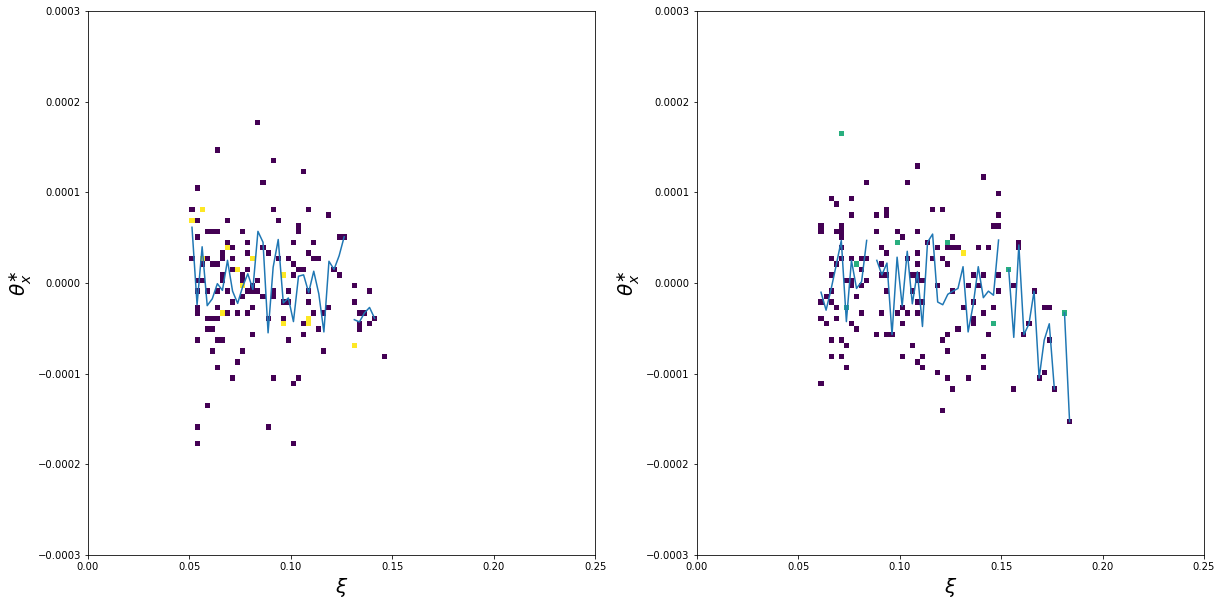

In [50]:
if proton_selection == "MultiRP":
    msk_data = ( df_data["InvMass"] >= 0. )
    # Multi-RP
    msk1_data = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk2_data = msk_data & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

    print ( len(df_data[ "Xi" ][ msk1_data ]), len(df_data[ "Xi" ][ msk2_data ]) )

    fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
    h_, xedges_, yedges_, im_ = axes[0].hist2d( df_data[ "Xi" ][ msk1_data ], df_data[ "ThX" ][ msk1_data ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[0].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[0].set_xlabel( r"$\xi$", fontsize=20 )
    axes[0].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )
    h_, xedges_, yedges_, im_ = axes[1].hist2d( df_data[ "Xi" ][ msk2_data ], df_data[ "ThX" ][ msk2_data ], bins=(100,100), range=( (0.,0.25), (-300.e-06,300.e-06) ), norm=LogNorm(), cmap='viridis' )
    bin_centres_x_ = ( xedges_[:-1] + xedges_[1:] ) / 2
    bin_centres_y_ = ( yedges_[:-1] + yedges_[1:] ) / 2
    axes[1].plot( bin_centres_x_, np.mean( (h_ * bin_centres_y_), axis=1) / np.mean( h_, axis=1) )
    axes[1].set_xlabel( r"$\xi$", fontsize=20 )
    axes[1].set_ylabel( r"$\theta_x^{\ast}$", fontsize=20 )

### Plot data vs MC

In [51]:
for label_ in df_signals_protons_multiRP_index:
    df_signals_protons_multiRP_index[ label_ ][ "xi_ratio" ] = ( 1. - df_signals_protons_multiRP_index[ label_ ][ "Xi" ] / df_signals_protons_multiRP_index[ label_ ][ "XiMuMu" ] )
    
df_bkg[ "xi_ratio" ] = ( 1. - df_bkg[ "Xi" ] / df_bkg[ "XiMuMu" ] )
df_data[ "xi_ratio" ] = ( 1. - df_data[ "Xi" ] / df_data[ "XiMuMu" ] )

In [62]:
def plot_data_mc( var, hist_bins, hist_range, df_data, df_mc_list, weights_mc_list, labels_mc, fig=None, ax=None ):
    if fig is None: fig = plt.figure( figsize=(12,10) )
    color=[ 'orange', 'darkblue', 'skyblue', 'lightblue' ]
    mc_data_var = [ df[ var ] for df in df_mc_list ]
    color = color[:len(mc_data_var)]
    
    ax_ = plt.gca() if ax is None else ax 
    ax_.hist(
        mc_data_var,
        color=color,
        weights=weights_mc_list, label=labels_mc,
        stacked=True, bins=hist_bins, range=hist_range )

    counts, bin_edges = np.histogram( df_data[ var ], bins=hist_bins, range=hist_range )
    errors = np.sqrt( counts )
    bin_centres = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
    ax_.errorbar(bin_centres, counts, yerr=errors, fmt='o', label='Data')
    
    return ( fig, ax_ )

In [63]:
msk1_data = None
msk2_data = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_data = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk2_data = ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_data = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk2_data = ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

df_data_1 = df_data[ msk1_data ]
df_data_2 = df_data[ msk2_data ]

# df_mc_list      = [ df_bkg, df_signals['SingleDissociation'], df_signals['Elastic'] ]
# weights_mc_list = [ df_bkg["norm"], df_signals['SingleDissociation']["norm"], df_signals['Elastic']["norm"] ]
# weights_mc_list = [ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ]_list = [ df_bkg["norm"], ( df_signals['SingleDissociation']["norm"] * df_signals['SingleDissociation']["eff_all_weighted"] ), ( df_signals['Elastic']["norm"] * df_signals['Elastic']["eff_all_weighted"] ) ]
df_mc_list = [
    df_bkg,
    df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Inel-El' ],
    df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Elastic' ]
    ]
weights_mc_list = [
    df_bkg["norm"],
    ( df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Inel-El' ]["norm"] * df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Inel-El' ]["eff_proton_all"] ),
    ( df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Elastic' ]["norm"] * df_signals_protons_multiRP_index[ 'GGToMuMu_Pt-25_Elastic' ]["eff_proton_all"] ) ]
labels_mc = [ "Background", "Single-dissociative", "Elastic"]

df_mc_list_1 = []
df_mc_list_2 = []

weights_mc_list_1 = []
weights_mc_list_2 = []
for idx_ in range( len( df_mc_list ) ):
    df_ = df_mc_list[idx_]
    
    msk1_ = None
    msk2_ = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 23 )
        msk2_ = ( df_["MultiRP"] == 0) & ( df_["RPId1"] == 123 )
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 0 )
        msk2_ = ( df_["MultiRP"] == 1 ) & ( df_["Arm"] == 1 )
        
    df_mc_list_1.append( df_[ msk1_ ] )
    df_mc_list_2.append( df_[ msk2_ ] )
    weights_mc_list_1.append( weights_mc_list[idx_][ msk1_ ] )
    weights_mc_list_2.append( weights_mc_list[idx_][ msk2_ ] )
    

(0.0, 22.745966692414832)

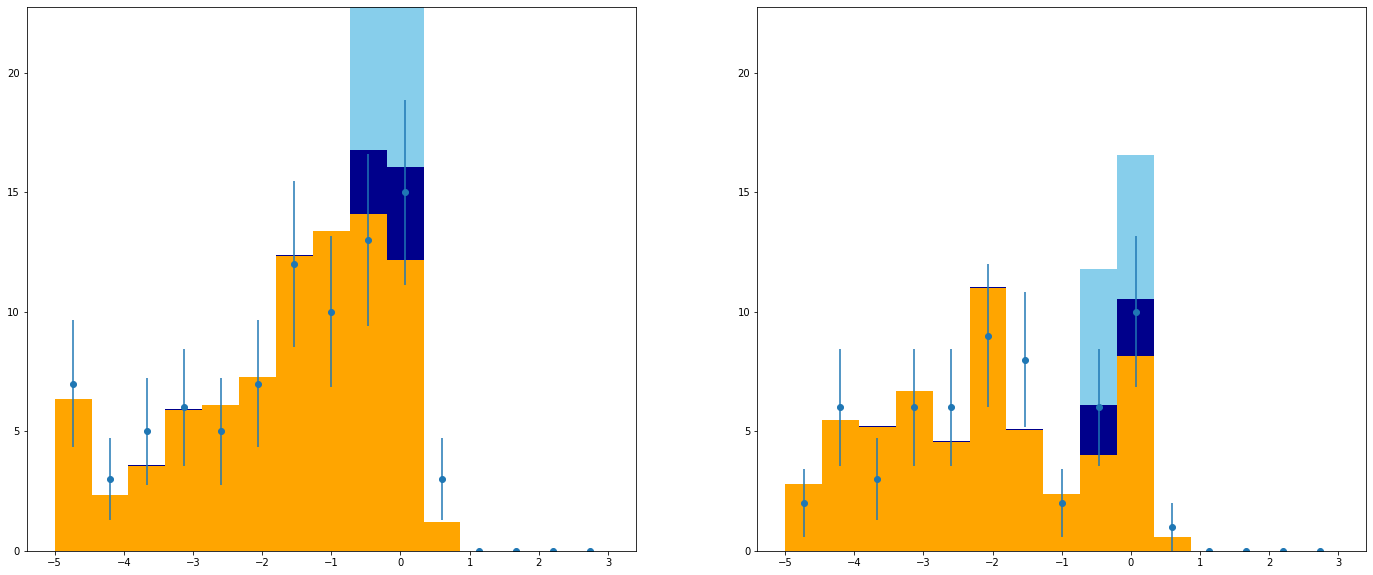

In [64]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

var_ = "xi_ratio"
hist_bins_ = 15
hist_range_ = (-5.,3.)

counts_1, _ = np.histogram( df_data_1[ var_ ], bins=hist_bins_, range=hist_range_ )
counts_2, _ = np.histogram( df_data_2[ var_ ], bins=hist_bins_, range=hist_range_ )
errors_1 = np.sqrt( counts_1 )
errors_2 = np.sqrt( counts_2 )
idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_]
y_max += np.max( [ 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_], 0.20*y_max ] )

fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
                          df_data=df_data_1,
                          df_mc_list=df_mc_list_1,
                          weights_mc_list=weights_mc_list_1, labels_mc=labels_mc,
                          fig=fig, ax=axes[0]
                          )
fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
                          df_data=df_data_2,
                          df_mc_list=df_mc_list_2,
                          weights_mc_list=weights_mc_list_2, labels_mc=labels_mc,
                          fig=fig, ax=axes[1]
                          )
axes[0].set_ylim( bottom=0., top=y_max )
axes[1].set_ylim( bottom=0., top=y_max )
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')

### Signal region

In [65]:
xi_ratio_min_ = -0.50
xi_ratio_max_ = +0.50

df_data_sel_1 = df_data_1[ ( df_data_1[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_data_1[ "xi_ratio" ] <= xi_ratio_max_ ) ]
df_data_sel_2 = df_data_2[ ( df_data_2[ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_data_2[ "xi_ratio" ] <= xi_ratio_max_ ) ]

df_mc_list_sel_1 = []
df_mc_list_sel_2 = []
weights_mc_list_sel_1 = []
weights_mc_list_sel_2 = []
for idx_ in range( len( df_mc_list ) ):
    msk1_ = ( df_mc_list_1[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_mc_list_1[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    msk2_ = ( df_mc_list_2[idx_][ "xi_ratio" ] >= xi_ratio_min_ ) & ( df_mc_list_2[idx_][ "xi_ratio" ] <= xi_ratio_max_ )
    df_mc_list_sel_1.append( df_mc_list_1[idx_][ msk1_ ] )
    df_mc_list_sel_2.append( df_mc_list_2[idx_][ msk2_ ] )
    weights_mc_list_sel_1.append( weights_mc_list_1[idx_][ msk1_ ] )
    weights_mc_list_sel_2.append( weights_mc_list_2[idx_][ msk2_ ] )

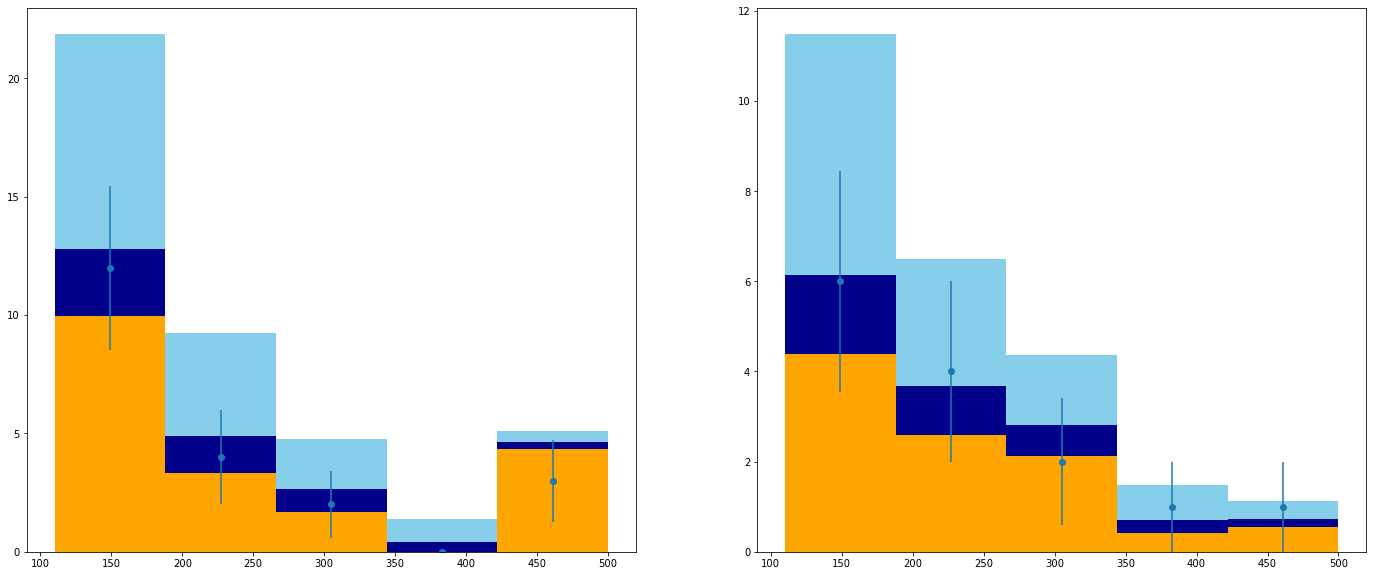

In [56]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

# var_ = "xi_ratio"
# hist_bins_ = 8
# hist_range_ = (-1.,1.)

# var_ = "Xi"
# hist_bins_ = 10
# hist_range_ = (0.05,0.15)

# var_ = "ThX"
# hist_bins_ = 10
# hist_range_ = (-0.0005,0.0005)

# var_ = "ThY"
# hist_bins_ = 10
# hist_range_ = (-0.0005,0.0005)

var_ = "InvMass"
hist_bins_ = 5
hist_range_ = (110.,500.)

fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
                          df_data=df_data_sel_1,
                          df_mc_list=df_mc_list_sel_1,
                          weights_mc_list=weights_mc_list_sel_1,
                          fig=fig, ax=axes[0]
                          )
fig_, ax_ = plot_data_mc( var_, hist_bins=hist_bins_, hist_range=hist_range_,
                          df_data=df_data_sel_2,
                          df_mc_list=df_mc_list_sel_2,
                          weights_mc_list=weights_mc_list_sel_2,
                          fig=fig, ax=axes[1]
                          )